In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy import stats
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier,
    StackingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score,
    log_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import xgboost as xgb
from xgboost import XGBClassifier

from collections import defaultdict


In [2]:
# Read the CSV file with specified data types
df = pd.read_csv('final_dataset.csv', low_memory=False)

In [3]:
print(df['manufactured_home_secured_property_type'].value_counts())

manufactured_home_secured_property_type
3.0    53728
1.0     1086
2.0       18
Name: count, dtype: int64


In [4]:
df.head()

action_taken  loan_type  lien_status  open_end_line_of_credit  loan_amount  \
0           3.0        3.0          1.0                      2.0     205000.0   
1           3.0        2.0          1.0                      2.0     155000.0   
2           3.0        2.0          1.0                      2.0     125000.0   
3           3.0        2.0          1.0                      2.0      55000.0   
4           3.0        1.0          1.0                      2.0     345000.0   

   combined_loan_to_value_ratio  interest_rate  total_loan_costs  \
0                          16.0            5.0               7.0   
1                           7.0            5.0               7.0   
2                           8.0            5.0               7.0   
3                           7.0            5.0               7.0   
4                           1.0            5.0               7.0   

   origination_charges  loan_term  ...  applicant_ethnicity_1  \
0                  1.0        6.0  ...                    2.0   
1                  1.0        6.0  ...                    2.0   
2                  1.0        6.0  ...                    2.0   
3                  1.0        6.0  ...                    2.0   
4                  1.0        3.0  ...                    2.0   

   co_applicant_ethnicity_1  applicant_race_1  applicant_race_2  \
0                       2.0               5.0               5.0   
1                       2.0               5.0               5.0   
2                       2.0               5.0               5.0   
3                       2.0               3.0               5.0   
4                       2.0               5.0               5.0   

   co_applicant_race_1  co_applicant_race_2  applicant_sex  co_applicant_sex  \
0                  5.0                  5.0            1.0               2.0   
1                  5.0                  5.0            2.0               1.0   
2                  5.0                  5.0            1.0               2.0   
3                  3.0                  5.0            1.0               2.0   
4                  5.0                  5.0            1.0               2.0   

   applicant_age  co_applicant_age  
0            7.0               4.0  
1            3.0               3.0  
2            4.0               3.0  
3            2.0               2.0  
4            2.0               2.0  

[5 rows x 33 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  float64
 1   loan_type                                 54832 non-null  float64
 2   lien_status                               54832 non-null  float64
 3   open_end_line_of_credit                   54832 non-null  float64
 4   loan_amount                               54832 non-null  float64
 5   combined_loan_to_value_ratio              54832 non-null  float64
 6   interest_rate                             54832 non-null  float64
 7   total_loan_costs                          54832 non-null  float64
 8   origination_charges                       54832 non-null  float64
 9   loan_term                                 54832 non-null  float64
 10  negative_amortization             

In [6]:
df['co_applicant_sex'].value_counts()

co_applicant_sex
2.0    39386
1.0    15421
6.0       25
Name: count, dtype: int64

In [7]:
random_state=42

In [8]:
# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [2.0, 3.0, 6.0],
    'co_applicant_sex': [6.0, 1.0],
    'applicant_race_1': [3.0],
    'co_applicant_race_1': [3.0],
    'applicant_ethnicity_1': [1.0],
    'co_applicant_ethnicity_1': [1.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Create a new DataFrame to store the resampled data
resampled_df = df.copy()

# Iterate through the columns and apply SMOTE to each
for column, minority_class in minority_classes.items():
    # Select the specific column
    selected_column = df[column].values.reshape(-1, 1)

    # Define y_min based on the minority class for this column
    y_min = [1 if value in minority_class else 0 for value in df[column]]

    # Apply SMOTE to the selected column
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled2, y_resampled2 = smote.fit_resample(selected_column, y_min)

    # Ensure that the resampled data has the same number of rows as the original DataFrame
    if len(X_resampled2) > len(df):
        X_resampled2 = X_resampled2[:len(df)]
        y_resampled2 = y_resampled2[:len(df)]

    # Update the resampled data in the new DataFrame
    resampled_df[column] = X_resampled2.flatten()

In [9]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  float64
 1   loan_type                                 54832 non-null  float64
 2   lien_status                               54832 non-null  float64
 3   open_end_line_of_credit                   54832 non-null  float64
 4   loan_amount                               54832 non-null  float64
 5   combined_loan_to_value_ratio              54832 non-null  float64
 6   interest_rate                             54832 non-null  float64
 7   total_loan_costs                          54832 non-null  float64
 8   origination_charges                       54832 non-null  float64
 9   loan_term                                 54832 non-null  float64
 10  negative_amortization             

C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

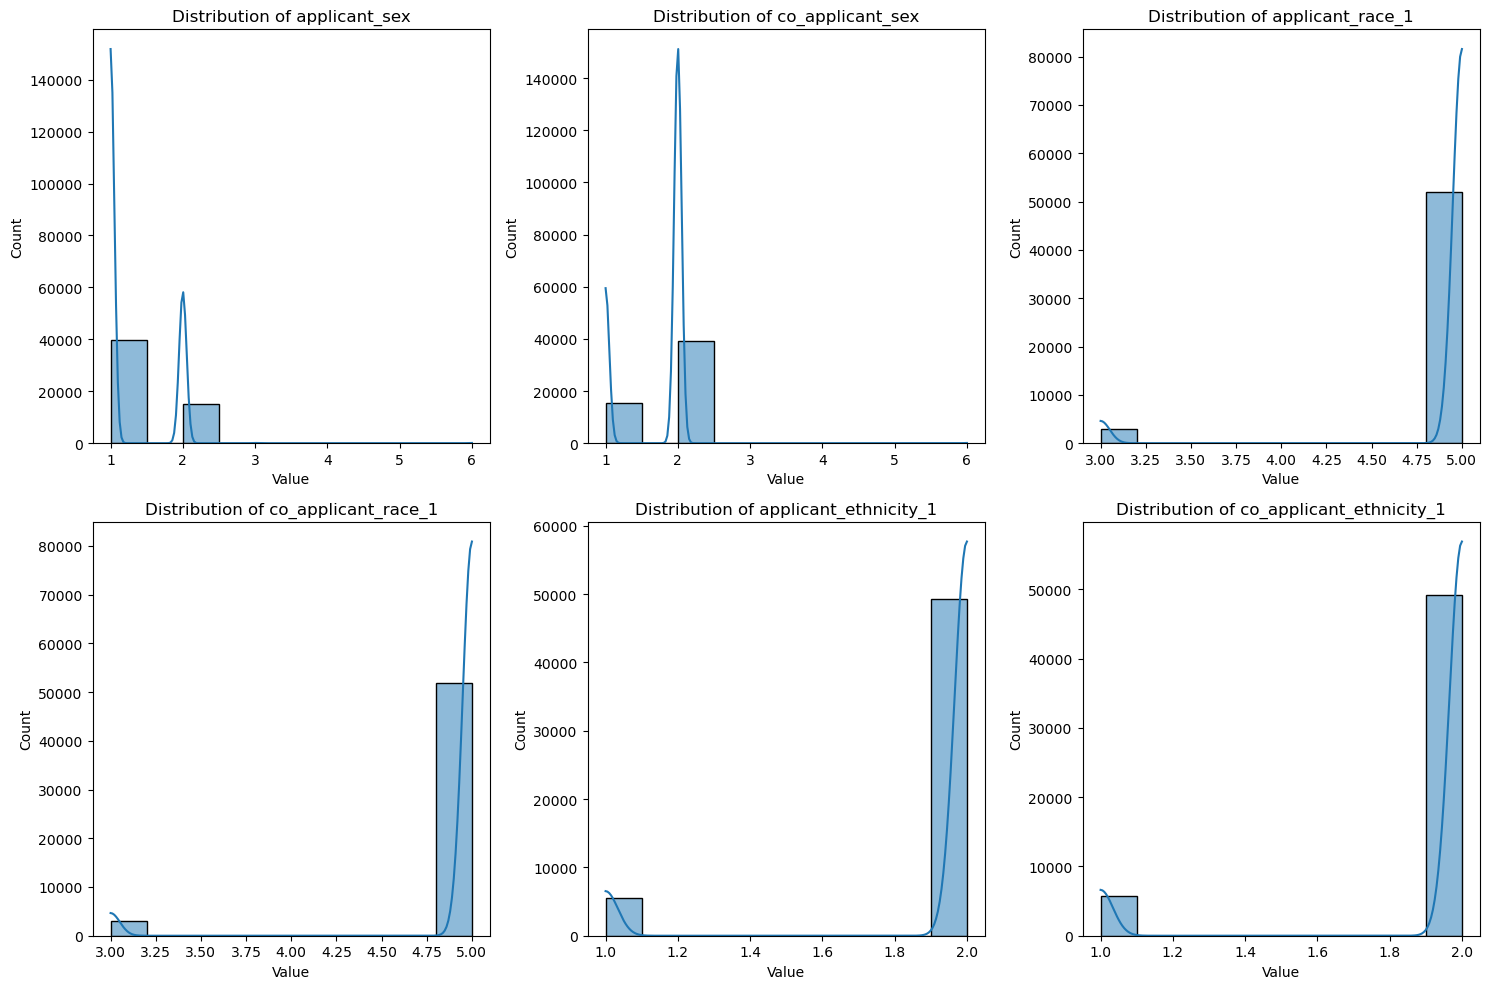

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of columns for which you want to plot the distribution
columns_to_plot = list(minority_classes.keys())

# Calculate the number of plots and rows
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    # Extract the resampled values for the current column from the resampled_df
    values = resampled_df[column]

    # Create a histogram plot
    g = sns.histplot(values, ax=axes[i], bins=10, kde=True)
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Logistic Regression

In [11]:
X = resampled_df.drop('action_taken', axis=1)
y = resampled_df['action_taken']

In [12]:
# Split your data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
column_mapping = {i: col for i, col in enumerate(X_train.columns)}
column_mapping

{0: 'loan_type',
 1: 'lien_status',
 2: 'open_end_line_of_credit',
 3: 'loan_amount',
 4: 'combined_loan_to_value_ratio',
 5: 'interest_rate',
 6: 'total_loan_costs',
 7: 'origination_charges',
 8: 'loan_term',
 9: 'negative_amortization',
 10: 'interest_only_payment',
 11: 'balloon_payment',
 12: 'other_nonamortizing_features',
 13: 'property_value',
 14: 'occupancy_type',
 15: 'manufactured_home_secured_property_type',
 16: 'manufactured_home_land_property_interest',
 17: 'total_units',
 18: 'income',
 19: 'debt_to_income_ratio',
 20: 'applicant_credit_score_type',
 21: 'co_applicant_credit_score_type',
 22: 'applicant_ethnicity_1',
 23: 'co_applicant_ethnicity_1',
 24: 'applicant_race_1',
 25: 'applicant_race_2',
 26: 'co_applicant_race_1',
 27: 'co_applicant_race_2',
 28: 'applicant_sex',
 29: 'co_applicant_sex',
 30: 'applicant_age',
 31: 'co_applicant_age'}

In [14]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=1.0) 
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")

The accuracy for training: 0.5703864128576314
The accuracy for validation: 0.568904593639576
F1 score for validation: 0.7208856088560887


C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

In [15]:
thresh_ps = np.linspace(.10, 1, 1000)
model_val_probs = LR.predict_proba(X_val)[:, 1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
best_f1_score, best_thresh_p = 0, 0  # Initialize best F1 score and threshold

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1 = f1_score(y_val, model_val_labels, average='micro')
    f1_scores.append(f1)
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_thresh_p = p

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

In [16]:
# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

ValueError: y_true takes value in {1.0, 3.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [17]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:


C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\asche\anaconda3\envs\jupyterlab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

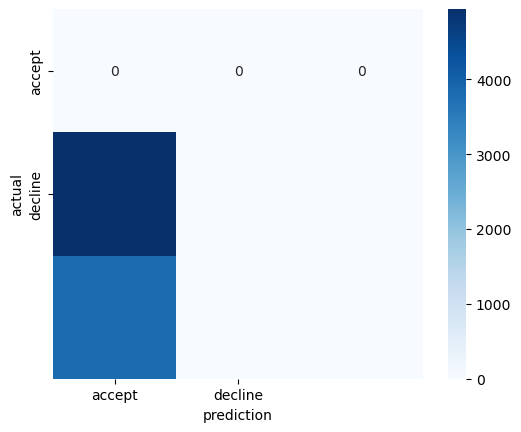

In [18]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))

In [ ]:
# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

In [ ]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# Naive Bayes

In [ ]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

# Ada Boost Classifier

In [ ]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

# Stochastic Gradient Descent Algorithm

In [ ]:
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [ ]:
# Add early stopping
early_stopping_rounds = 3

xgb_model1 = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds)

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
}

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model1, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set)

In [ ]:
clf.best_params_

In [ ]:
# Define your hyperparameters
params = {'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [ ]:
X_train

In [ ]:
# Train the model and monitor early stopping
xgb_model1.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model1.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

In [ ]:
X_train.info()

In [ ]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model1, file)

In [ ]:
import xgboost as xgb

# Assuming xgb_model1 is your trained XGBoost model
booster = xgb_model1.get_booster()

# Get feature names
feature_names = booster.feature_names
print(feature_names)

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model1 is your trained XGBoost model
xgb.plot_importance(xgb_model1)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you already have y_test and y_predict from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Make test data for the webapp

We create a json file.
it contains 5 accepted rows and 5 declined rows.
We feed this to the form in our webapp to test predictions. 

In [ ]:
accepted_counter = 0  # Initialize the accepted counter
dummy_data = []  # List to store the dummy data

for index, target_value in enumerate(y_test):
    if target_value == 1.0 and accepted_counter < 3:
        dummy_name = f"acceptedDummy{accepted_counter + 1}"
        print(index)
        dummy_row = X_test.iloc[index].copy()  # Create a copy of the row
        dummy_row['action_taken'] = 1.0  # Set the action_taken value to 1.0 for accepted
        dummy_data.append((dummy_name, dummy_row))
        accepted_counter += 1

dummy_data


## Make a list of a few predictions and mirror them vs true labels.

In [ ]:
X_test

In [ ]:
# Initialize lists to store predictions and true values
predictions = []
true_values = []

def make_predictions(xgb_model1, X_test, y_test, num_predictions=5):
    # Make predictions for the test dataset
    for _, testX in X_test.iterrows():
        yhat = xgb_model1.predict([testX.values])  # Make a one-step prediction
        predictions.append(yhat[0])  # Store the prediction

    # Make predictions for the true values
    for true_value in y_test:
        true_values.append(true_value)  # Store the true value

    # Return lists of predictions and true values
    return predictions[:num_predictions], true_values[:num_predictions]

# Example usage:
preds, true_vals = make_predictions(xgb_model1, X_test, y_test, num_predictions=5)

# Display the results
print("Predictions:", preds)
print("True Values:", true_vals)


### See which rows are accepted.

In [ ]:
# Create a DataFrame with predictions and true values
results_df = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

# Filter rows where Predictions are 1 (accepted)
accepted_rows = results_df[results_df['Predictions'] == 1]

# Display the accepted rows
print(accepted_rows)

### Pick a specific accepted row and see its values.

In [ ]:
import joblib
model_xgboost = joblib.load('xgboost_model.pkl') 

In [ ]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

In [ ]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

In [ ]:
row = X_test.iloc[147]
print(row)
true_label = y_test.iloc[147]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

In [ ]:
row = X_test.iloc[147]
true_label = y_test.iloc[147]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

In [ ]:
# Ensure that data_values has the correct format and values
data_values = X_test.iloc[6]  # accept: 0,3,6
data_values

In [ ]:
# problematic prediction
prediction2 = model_xgboost.predict([data_values])
print(prediction2)  # This should be 1 if data_values now match the expected format and values

In [ ]:
row1 = X_test.iloc[147]
np.save('row1.npy', row1)
row1

In [ ]:
# correct prediction
prediction1 = model_xgboost.predict([row1])
print(prediction1)

# Pickle models

In [ ]:
lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [ ]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [ ]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [ ]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

# voting classifer (HARD)

In [ ]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

In [ ]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

In [ ]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

# Compare all the models.

In [ ]:
# Example model and prediction data
models = ['LR', 'knn', 'Ada Boost', 'Gaussian', 'Stochastic Gradient Descent', 'xgb_model1', 'Decision Tree', 'SGD_model', 'voting_classifier']
y_pred1 = LR.predict(X_val)
y_pred2 = knn.predict(X_val)
y_pred3 = AB_CLF.predict(X_val)
y_pred4 = Gaussian.predict(X_val)
y_pred5 = SG_PIP_CLF.predict(X_val)
y_pred6 = xgb_model1.predict(X_val)
y_pred7 = dt_model.predict(X_val)
y_pred8 = SGD_model.predict(X_val)
y_pred9 = voting_classifer.predict(X_val)  
 

y_true = y_val  # True labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': [accuracy_score(y_true, y_pred1), accuracy_score(y_true, y_pred2), accuracy_score(y_true, y_pred3),
                 accuracy_score(y_true, y_pred4), accuracy_score(y_true, y_pred5), accuracy_score(y_true, y_pred6),
                 accuracy_score(y_true, y_pred7), accuracy_score(y_true, y_pred8), accuracy_score(y_true, y_pred9)],
    
    'Precision': [precision_score(y_true, y_pred1), precision_score(y_true, y_pred2), precision_score(y_true, y_pred3),
                  precision_score(y_true, y_pred4), precision_score(y_true, y_pred5), precision_score(y_true, y_pred6),
                  precision_score(y_true, y_pred7), precision_score(y_true, y_pred8), precision_score(y_true, y_pred9)],
    
    'Recall': [recall_score(y_true, y_pred1), recall_score(y_true, y_pred2), recall_score(y_true, y_pred3),
               recall_score(y_true, y_pred4), recall_score(y_true, y_pred5), recall_score(y_true, y_pred6),
               recall_score(y_true, y_pred7), recall_score(y_true, y_pred8), recall_score(y_true, y_pred9)],
    
    'F1 Score': [f1_score(y_true, y_pred1), f1_score(y_true, y_pred2), f1_score(y_true, y_pred3),
                 f1_score(y_true, y_pred4), f1_score(y_true, y_pred5), f1_score(y_true, y_pred6),
                 f1_score(y_true, y_pred7), f1_score(y_true, y_pred8), f1_score(y_true, y_pred9)]
}

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(metrics, index=models)

# Display the DataFrame
print(df)
